In [1]:
import collections
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import copy
import math
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from common.optim.meta import MetaData
from common.optim.optimise_v6_light import NetLineStepProcessor
from common.util import AverageMeter, loss_crossentropy_np
from common.cnn import make_resnet9

from torchvision.datasets import CIFAR10
from torchvision import transforms

import logging

In [2]:
logging.basicConfig(filename="logs/cifar10_restnet9_comparison_graphs.log",
                level=logging.INFO,
                format="%(levelname)s: %(asctime)s %(message)s")
                #datefmt="%m/%d/%Y %I:%M:%S")


#### Constants

In [3]:
BATCH_SIZE = 128 #256
OUTPUT_DIM=10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EXPERIMENTS = 1 #3 #10
EPOCHS_PER_EXPERIMENT = 100 #50
DATASET_PATH = "./datasets"

#### CIFAR10 dataset

In [4]:
'''
base_transforms = transforms.ToTensor()
aug_transforms = transforms.RandomHorizontalFlip(p=0.5)

train_transforms = transforms.Compose([
    base_transforms,
    aug_transforms
])
'''
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(*stats,inplace=True)])
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=train_transforms)
test_dataset = CIFAR10(root=DATASET_PATH, train=False, download=True, transform=valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


##### UTILS

In [5]:
def calculate_accuracy(prediction, target):
    return np.average((prediction ==target).detach().cpu())

def test_loop(testNet):
    accuracy_meter, loss_meter  = AverageMeter(), AverageMeter()
    testNet.train(False)
    with torch.no_grad():
        for test_batch in test_dataloader:
            images, labels = test_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                logits = testNet.forward(images).detach().cpu()

                prediction = logits.argmax(dim=-1).to(DEVICE)
                loss = loss_crossentropy_np(np.transpose(logits.numpy()), labels)
                loss_meter.update(loss)
                accuracy_meter.update(calculate_accuracy(prediction, labels))

    return accuracy_meter.avg, loss_meter.avg

#### Compare optimisers

In [6]:
def experiment_comparison(data, var, low, high, title="Comparison"):

    MEAN_ADAM = data[low:high,0]
    MEAN_NETLINE = data[low:high,1]
    MEAN_SGD = data[low:high,2]
    if (var is not None):
        low, up = data[low:high]-var[low:high], data[low:high]+var[low:high]
        LOW_ADAM, UP_ADAM = low[:,0], up[:,0]
        LOW_NETLINE, UP_NETLINE = low[:,1], up[:,1]
        LOW_SGD, UP_SGD = low[:,2], up[:,2]
        cord_x = np.arange(0, len(MEAN_ADAM[:,1]))

    #display.clear_output()
    fig, axes = plt.subplots(5, 2, figsize=(18, 30))
    axes[0,0].set_title('Loss (average cross entropy)')
    axes[0,0].plot(MEAN_ADAM[:,1], color='g',alpha=.5, label='Adam')
    if (var is not None):
        axes[0,0].fill_between(x=cord_x, y1=LOW_ADAM[:,1], y2=UP_ADAM[:,1], color='g', alpha=.125)
    axes[0,0].plot(MEAN_NETLINE[:,1], color='b',alpha=.5, label='Net-line')
    if (var is not None):
        axes[0,0].fill_between(x=cord_x, y1=LOW_NETLINE[:,1], y2=UP_NETLINE[:,1], color='b', alpha=.125)
    axes[0,0].plot(MEAN_SGD[:,1], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[0,0].fill_between(x=cord_x, y1=LOW_SGD[:,1], y2=UP_SGD[:,1], color='grey', alpha=.125)
    axes[0,0].grid()
    axes[0,0].legend()
    axes[0,0].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0,0].set_ylabel("Loss value")

    axes[0,1].set_title('Accuracy (top 1)')
    axes[0,1].plot(MEAN_ADAM[:,0], color='g', alpha=.5, label='Adam')
    if (var is not None):
        axes[0,1].fill_between(x=cord_x, y1=LOW_ADAM[:,0], y2=UP_ADAM[:,0], color='g', alpha=.125)
    axes[0,1].plot(MEAN_NETLINE[:,0], color='b', alpha=.5, label='Net-line')
    if (var is not None):
        axes[0,1].fill_between(x=cord_x, y1=LOW_NETLINE[:,0], y2=UP_NETLINE[:,0], color='b', alpha=.125)
    axes[0,1].plot(MEAN_SGD[:,0], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[0,1].fill_between(x=cord_x, y1=LOW_SGD[:,0], y2=UP_SGD[:,0], color='grey', alpha=.125)
    axes[0,1].grid()
    axes[0,1].legend()
    axes[0,1].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0,1].set_ylabel("Accuracy value")
    axes[1,0].set_title('PQ vector norm')
    axes[1,0].plot(MEAN_NETLINE[:,4], color='grey',alpha=.5, label='PQ vector norm average per epoch')
    axes[1,1].set_title('QQ vector norm')
    axes[1,1].plot(MEAN_NETLINE[:,3], color='grey',alpha=.5, label='QQ vector norm average per epoch')
    axes[2,0].set_title('Cos phi')
    axes[2,0].plot(MEAN_NETLINE[:,5], color='grey',alpha=.5, label='Cos phi average per epoch')
    axes[2,1].set_title('Eta calculated')
    axes[2,1].plot(MEAN_NETLINE[:,6], color='grey',alpha=.5, label='Eta average per epoch')
    axes[3,0].set_title('Armiho coeff')
    axes[3,0].plot(MEAN_NETLINE[:,8], color='grey',alpha=.5, label='Armiho coeff per epoch')
    axes[3,1].set_title('Wolf coeff')
    axes[3,1].plot(MEAN_NETLINE[:,9], color='grey',alpha=.5, label='Wolf coeff per epoch')
    axes[4,0].set_title('Alpha')
    axes[4,0].plot(MEAN_NETLINE[:,7], color='grey',alpha=.5, label='Alpha per epoch')    
    dummy=fig.suptitle(title)

    plt.show()

def experiment_params_detailed(data, low, high, title="Params detailed"):
    MEAN_NETLINE = data[low:high,1]
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    axes[0,0].set_title('PQ vector norm')
    axes[0,0].plot(MEAN_NETLINE[:,4], color='grey',alpha=.5, label='PQ vector norm average per epoch')
    axes[0,1].set_title('QQ vector norm')
    axes[0,1].plot(MEAN_NETLINE[:,3], color='grey',alpha=.5, label='QQ vector norm average per epoch')
    axes[1,0].set_title('Cos phi')
    axes[1,0].plot(MEAN_NETLINE[:,5], color='grey',alpha=.5, label='Cos phi average per epoch')
    axes[1,1].set_title('Eta calculated')
    axes[1,1].plot(MEAN_NETLINE[:,6], color='grey',alpha=.5, label='Eta average per epoch')
    axes[2,0].set_title('Alpha')
    axes[2,0].plot(MEAN_NETLINE[:,7], color='grey',alpha=.5, label='Alpha per epoch')
    axes[2,1].set_title('Armiho coeff')
    axes[2,1].plot(MEAN_NETLINE[:,8], color='grey',alpha=.5, label='Armiho coeff per epoch')
    dummy=fig.suptitle(title)

    plt.show()

def timing_comparison(data, low, high, title="Comparison"):
    TIMING_ADAM = data[low:high,0]
    TIMING_NETLINE = data[low:high,1]
    TIMING_SGD = data[low:high,2]

    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes.set_title(title)
    axes.plot(TIMING_ADAM[:,2], color='g',alpha=.5, label='Adam')
    axes.plot(TIMING_NETLINE[:,2], color='b',alpha=.5, label='Net-line')
    axes.plot(TIMING_SGD[:,2], color='grey', alpha=.5, label='SGD')
    axes.grid()
    axes.legend()
    axes.set_xlabel("Epoch (series of gradient descent steps)")
    axes.set_ylabel("Time ns")
    plt.show()

def rf(value):
    return f"{value:.5f}"

def accuracy_comparison(exp_results, low, high, title="Validation accuracy"):
    adam_mean, adam_var = np.mean(exp_results[:, low:high, 0, 0], axis=0), np.var(exp_results[:, low:high, 0, 0], axis=0)
    nline_mean, nline_var = np.mean(exp_results[:, low:high, 1, 0], axis=0), np.var(exp_results[:, low:high, 1, 0], axis=0)
    sgd_mean, sgd_var = np.mean(exp_results[:, low:high, 2, 0], axis=0), np.var(exp_results[:, low:high, 2, 0], axis=0)

    p1, p2, p3, p4 = min(10,EPOCHS_PER_EXPERIMENT), min(20,EPOCHS_PER_EXPERIMENT)\
        , min(30,EPOCHS_PER_EXPERIMENT), min(50,EPOCHS_PER_EXPERIMENT)

    report = np.zeros((3,4), dtype='U256')
    for row in range(3):
        for col in range(4):
            mean, var = (adam_mean, adam_var) if row == 0 else (nline_mean, nline_var) if row == 1 else (sgd_mean, sgd_var)
            indx = p1-1 if col == 0 else p2-1 if col == 1 else p3-1 if col == 2 else p4-1
            report[row, col] = rf(mean[indx]) + "+/-" + rf(var[indx])

    fig, ax = plt.subplots(figsize=(8, 8))
    # hide axes
    #fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    tab_plot = ax.table(cellText=report, colLabels=[str(p1)+' epochs',str(p2)+' epochs',str(p3)+' epochs',str(p4)+' epochs']\
        , rowLabels=['Adam','Net-line','SGD'], cellLoc='left', loc='center')
    tab_plot.auto_set_font_size(False)
    tab_plot.set_fontsize(11)
    tab_plot.scale(3, 4)
    #fig.tight_layout()
    ax.set_title(title)
    plt.show()

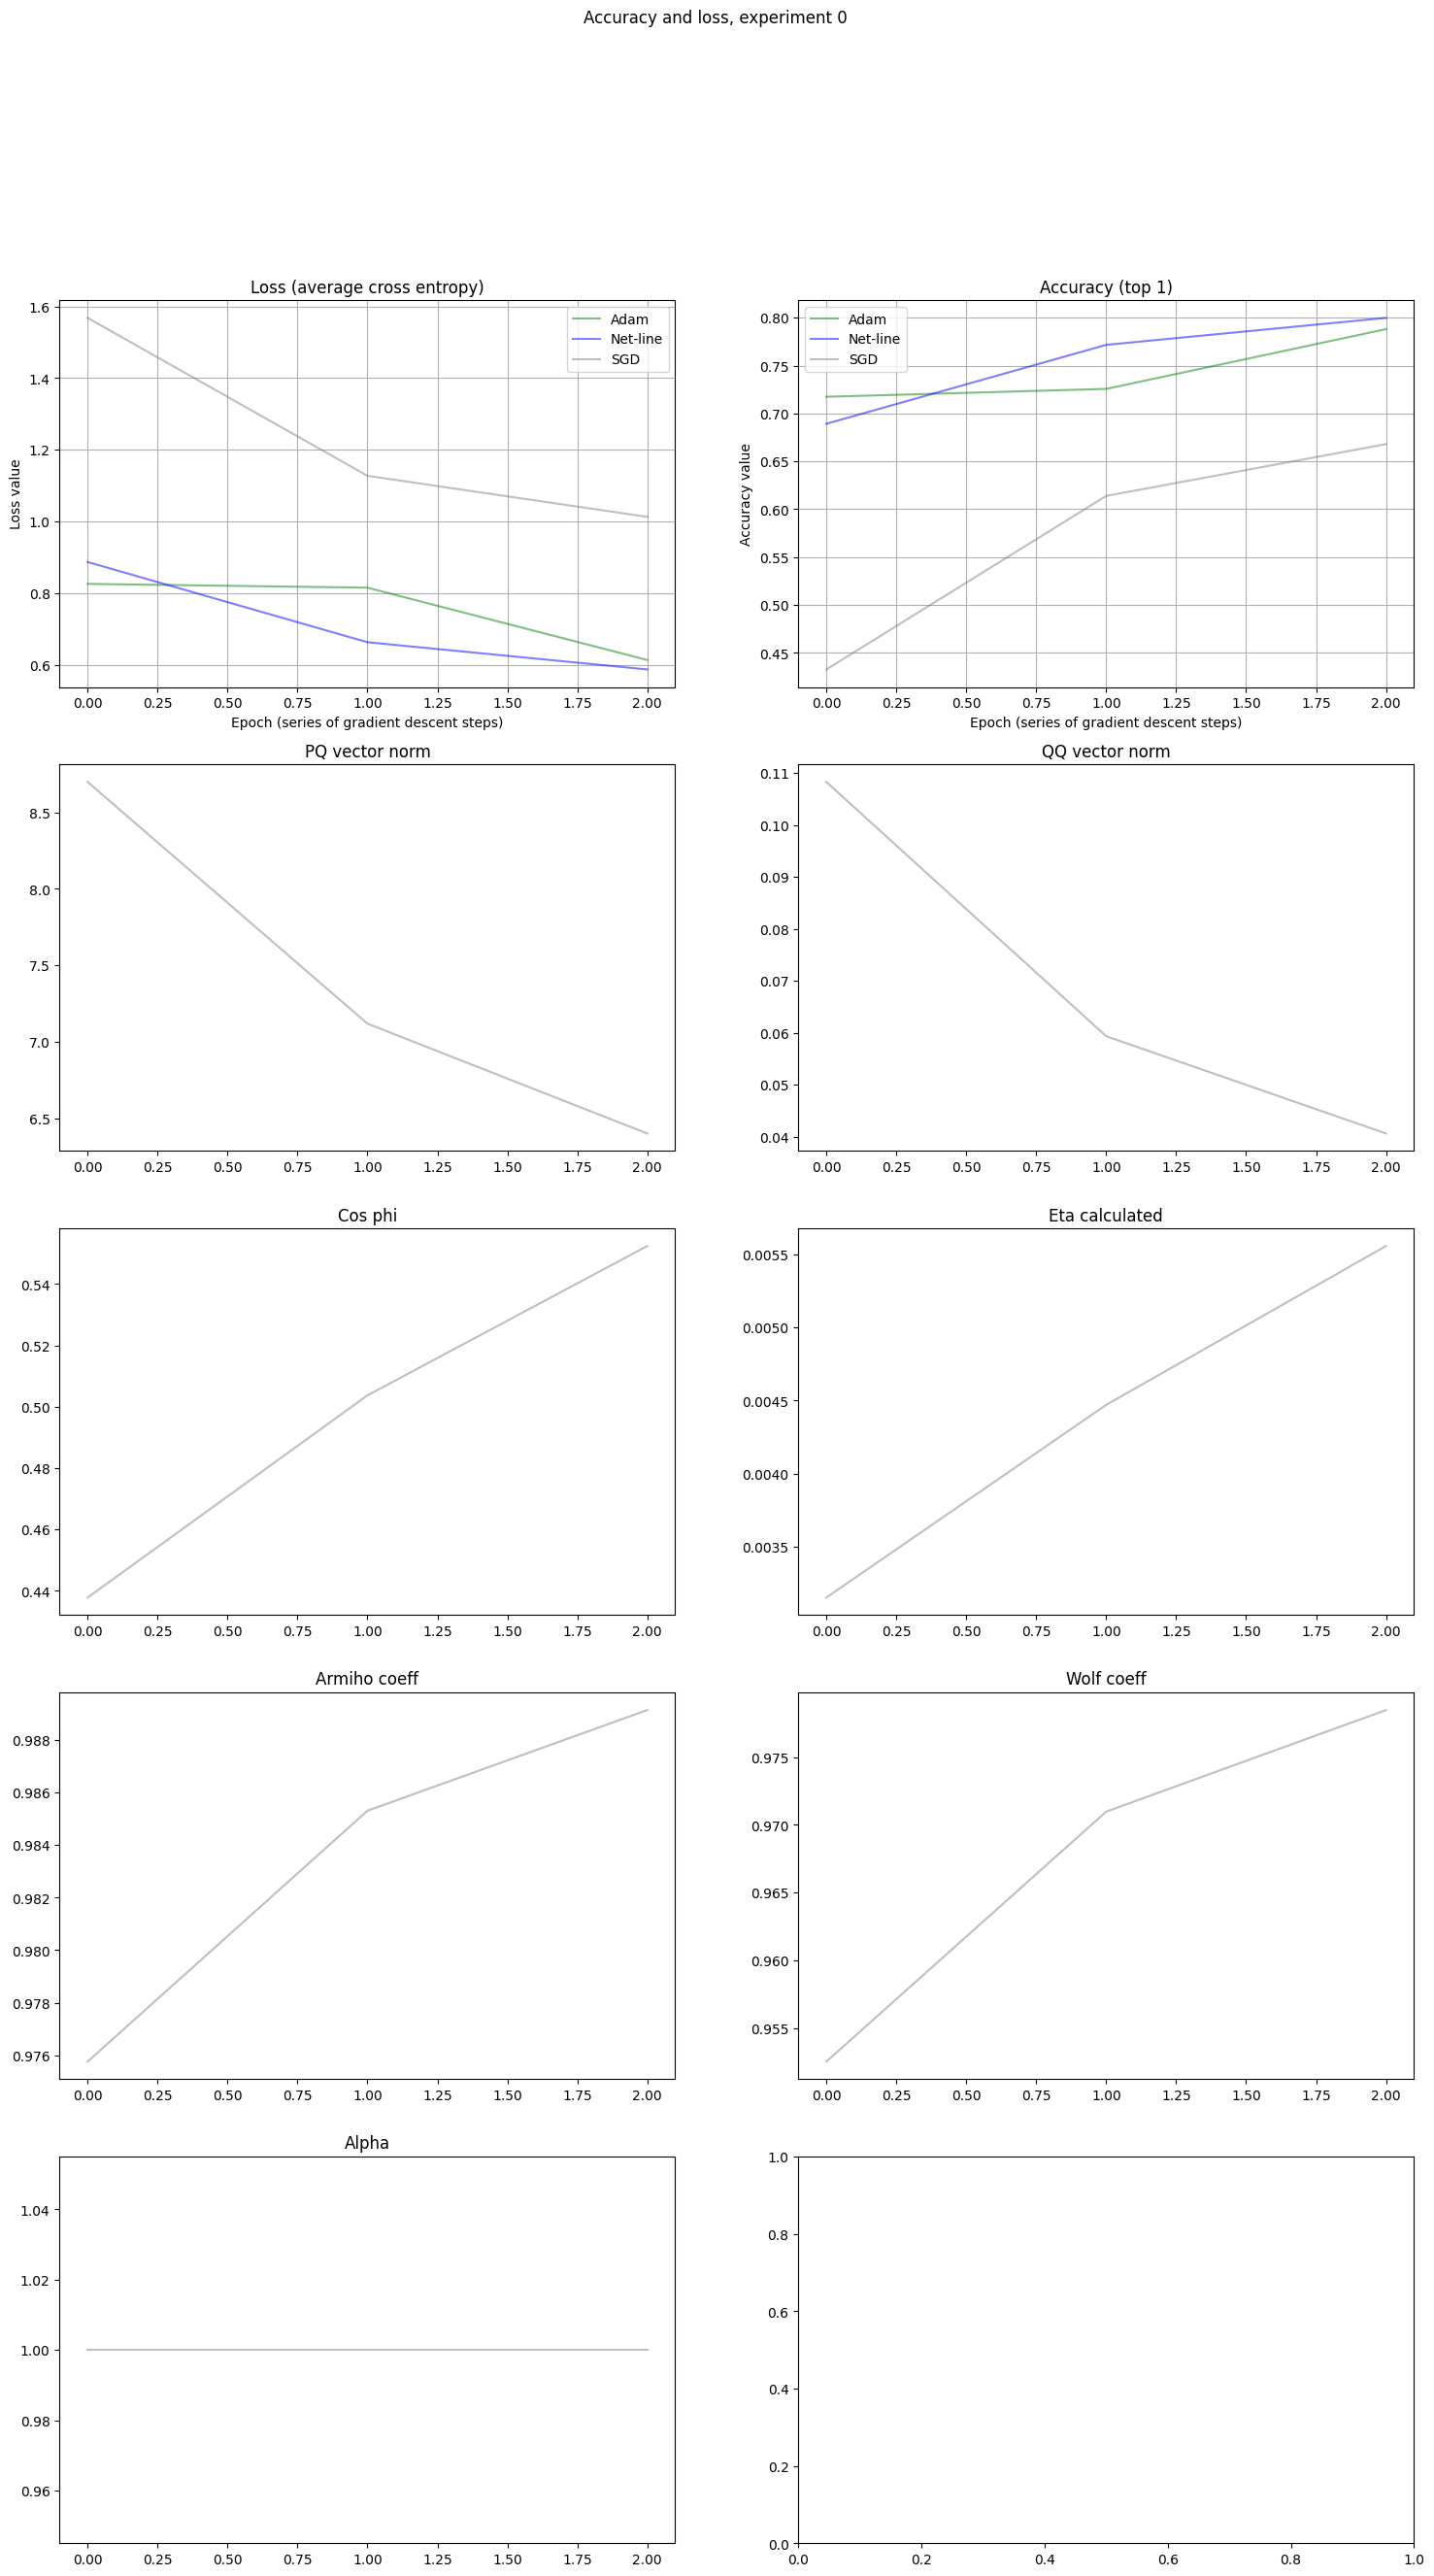

Experiment=0, sgd=0.6680181962025317, net-line=0.7998417721518988, adam=0.7880735759493671, alpha=1.0, beta=0.025


KeyboardInterrupt: 

In [7]:
meta = MetaData(batch_size = BATCH_SIZE, output_dim=OUTPUT_DIM, device=DEVICE)

'''
0-num of experiment; 1-epoch;
2-net: 0-Adam, 1-Net-line 2step, 2-SGD
3-param: 0-test accuracy (Top-1), 1-test errror (cross-entropy), 2-time per step, 3 - qq_norm_test,
4 - pq_norm, 5 - cos_phi, 6 - eta_calculated, 7 - alpha, 8 - armiho_coeff, 9 - wolf_coeff
'''
experimental_results = np.zeros((EXPERIMENTS, EPOCHS_PER_EXPERIMENT, 3, 10))
eta_fixed = 0.01
alpha_mult = 2.0**(1/10)

for experiment in range(EXPERIMENTS):

    #Adam
    net_adam = make_resnet9(3, OUTPUT_DIM).to(DEVICE)
    loss_adam = nn.CrossEntropyLoss()
    opt_adam = optim.Adam(net_adam.parameters(), lr=0.001)

    #Net-line 2step
    net_linestep = copy.deepcopy(net_adam)
    opt_linestep = NetLineStepProcessor(net_linestep, nn.CrossEntropyLoss(), meta, DEVICE)
    opt_linestep.eta1 = 0.0001
    opt_linestep.alpha = 1.0 #0.8 #0.005 #0.25
    opt_linestep.beta = 0.025
    opt_linestep.gamma = 0.1 #1e-09 #0.01 #0.0025
    opt_linestep.delta = 0.25
    opt_linestep.training_mode=False
    opt_linestep.do_logging=True
    opt_linestep.quadratic_step = True
    #step_params = {"extrastep": True}

    #Sgd scheduled lr
    net_sgd = copy.deepcopy(net_adam)
    loss_sgd = nn.CrossEntropyLoss()
    opt_sgd = optim.SGD(net_sgd.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

    for epoch in range(EPOCHS_PER_EXPERIMENT):
        #alpha, beta for net-line
        loss_data, pq_data, qq_data, cos_data = \
            experimental_results[experiment, 0:epoch, 1, 1],  experimental_results[experiment, 0:epoch, 1, 4]\
            ,  experimental_results[experiment, 0:epoch, 1, 3],  experimental_results[experiment, 0:epoch, 1, 5]
        loss_change = 1.0 if len(loss_data) <= 1 else (loss_data[-2]-loss_data[-1])/loss_data[-1]
        #qq_change = 1.0 if len(qq_data) <= 1 else (qq_data[-2]*cos_data[-2]-qq_data[-1]*cos_data[-1])/(qq_data[-1]*cos_data[-1])
        qq_change = 1.0 if len(qq_data) <= 1 else (qq_data[-2]-qq_data[-1])/qq_data[-1]
        pq_change = 1.0 if len(pq_data) <= 1 else (pq_data[-2]*cos_data[-2]-pq_data[-1]*cos_data[-1])/(pq_data[-1]*cos_data[-1])

        '''
        if loss_change > -0.01: #0.025:
            opt_linestep.alpha = opt_linestep.alpha*alpha_mult
        if loss_change < -0.01:
            opt_linestep.alpha = opt_linestep.alpha * (1/2)**(1/4) #1/2 if epoch<20 else
        '''

        #opt_linestep.alpha = min(opt_linestep.alpha, 0.8 * math.exp(-epoch/200))
        #opt_linestep.beta = 0.1 #if epoch < 10 else 0.25 if epoch < 15 else 0.5 if epoch < 20 else 0.67 #if epoch < 30 else 0.75 if epoch < 50 else 0.8

        #lr for SGD
        lr = eta_fixed if epoch < 20 else eta_fixed * 0.1 if epoch < 40 else eta_fixed * 0.01
        opt_sgd.param_groups[0]['lr'] = lr

        mt_adam, mt_netline, mt_sgd, mt_qq, mt_pq, mt_cos, mt_eta, mt_armiho, mt_wolf = \
            AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
        net_adam.train(True)
        net_linestep.train(True)
        net_sgd.train(True)

        for train_batch in train_dataloader:
            images, labels = train_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logging.info("####Step with Adam, eta={}".format(opt_adam.param_groups[0]['lr']))
            ns_start = time.time_ns()
            logits0 = net_adam.forward(images)
            loss0 = loss_adam(logits0, labels)
            opt_adam.zero_grad()
            loss0.backward()
            opt_adam.step()
            ns_end = time.time_ns()
            mt_adam.update(ns_end-ns_start)

            logging.info("####Step with net-line 2step")
            ns_start = time.time_ns()
            step_result = opt_linestep.step(labels, images, momentum=0.9, nesterov=True, weight_decay=5e-3)
            ns_end = time.time_ns()
            mt_netline.update(ns_end-ns_start)
            mt_pq.update(step_result.pq_norm)
            mt_qq.update(step_result.qq_norm)
            mt_cos.update(step_result.cos_phi)
            mt_eta.update(step_result.eta)
            mt_armiho.update(step_result.ck_armiho)
            mt_wolf.update(step_result.ck_wolf)

            logging.info("####Step with SGD, eta={}".format(opt_sgd.param_groups[0]['lr']))
            ns_start = time.time_ns()
            logits1 = net_sgd.forward(images)
            loss1 = loss_sgd(logits1, labels)
            opt_sgd.zero_grad()
            loss1.backward()
            opt_sgd.step()
            ns_end = time.time_ns()
            mt_sgd.update(ns_end-ns_start)

        #qq_norm, pq_norm, cos_phi
        experimental_results[experiment, epoch, 1, 3] = mt_qq.avg
        experimental_results[experiment, epoch, 1, 4] = mt_pq.avg
        experimental_results[experiment, epoch, 1, 5] = mt_cos.avg
        experimental_results[experiment, epoch, 1, 6] = mt_eta.avg
        experimental_results[experiment, epoch, 1, 7] = opt_linestep.alpha
        experimental_results[experiment, epoch, 1, 8] = mt_armiho.avg
        experimental_results[experiment, epoch, 1, 9] = mt_wolf.avg
        #timing
        experimental_results[experiment, epoch, 0, 2] = mt_adam.avg
        experimental_results[experiment, epoch, 1, 2] = mt_netline.avg
        experimental_results[experiment, epoch, 2, 2] = mt_sgd.avg

        # testing loop 0-Adam, 1-Net-line 2step, 2-SGD
        acc0, loss0 = test_loop(net_adam)
        experimental_results[experiment, epoch, 0, 0] = acc0
        experimental_results[experiment, epoch, 0, 1] = loss0

        acc1, loss1 = test_loop(net_linestep)
        experimental_results[experiment, epoch, 1, 0] = acc1
        experimental_results[experiment, epoch, 1, 1] = loss1

        acc2, loss2 = test_loop(net_sgd)
        experimental_results[experiment, epoch, 2, 0] = acc2
        experimental_results[experiment, epoch, 2, 1] = loss2

        display.clear_output()
        title="Accuracy and loss, experiment {}".format(experiment)
        experiment_comparison(experimental_results[experiment, 0:epoch+1], None, 0, 100, title=title)

        print("Experiment={}, sgd={}, net-line={}, adam={}, alpha={}, beta={}"\
            .format(experiment, acc2, acc1, acc0, opt_linestep.alpha, opt_linestep.beta))


In [ ]:
experimental_mean = np.mean(experimental_results, axis=0)
experimental_var = np.var(experimental_results, axis=0)

display.clear_output()
title2="Validation on CIFAR10 dataset"
experiment_comparison(experimental_mean[0:epoch+1], experimental_var[0:epoch+1], 0, 100, title=title2)


In [ ]:
title2="Time per step averaged by epochs and among {} experiments".format(EXPERIMENTS)
timing_comparison(experimental_results[experiment, 0:epoch+1], 0, 100, title=title2)

In [ ]:
#experimental_results[2, 0:100, 1, 0]
title3 = "Validation accuracy mean +/- var on CIFAR-10"
accuracy_comparison(experimental_results, 0, EPOCHS_PER_EXPERIMENT, title=title3)